# Demo - Evaluation - Siren (PyTorch)

In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root, local
root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [2]:
from pathlib import Path
import argparse
import wandb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# # Ensure TF does not see GPU and grab all GPU memory.
# import tensorflow as tf
# tf.config.set_visible_devices([], device_type='GPU')

# os.environ["JAX_PLATFORM_NAME"] = "CPU"
# # ENSURE JAX DOESNT PREALLOCATE
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = str(False)

import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from models.siren_torch import add_model_args
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.argparse import add_argparse_args

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import loguru

### Arguments

In [4]:
# ige/nerf4ssh/akq2iv1z
# ige/nerf4ssh/3jxcg0xh
wandb_id = "3jxcg0xh"
entity = "ige"
project = "nerf4ssh"
resume = True
mode = "online"

### Logger


In [5]:
# init wandb logger
wandb_logger = WandbLogger(
    id=wandb_id,
    mode=mode,
    project=project,
    entity=entity,
    resume=resume,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (ige). Use `wandb login --relogin` to force relogin
2022-06-05 14:01:35.534790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [6]:
args = wandb_logger.experiment.config

In [7]:
args.train_data_dir = "/home/johnsonj/data/dc_2021/raw/train"
args.ref_data_dir = "/home/johnsonj/data/dc_2021/raw/ref"
args.test_data_dir = "/home/johnsonj/data/dc_2021/raw/test"

### Load Data

In [8]:
%%time

# load data
data = load_data(args)

100%|██████████| 6/6 [00:00<00:00, 12.59it/s]


CPU times: user 452 ms, sys: 424 ms, total: 876 ms
Wall time: 1 s


In [9]:
# preprocess data
data = preprocess_data(data, args)

In [10]:
data[data.attrs["input_cols"]].describe()

,longitude,latitude
count,1.790094e+06,1.790094e+06
mean,3.014897e+02,3.581542e+01
std,8.457194e+00,7.822792e+00
min,2.850000e+02,2.300002e+01
25%,2.945217e+02,2.922090e+01
50%,3.019900e+02,3.538647e+01
75%,3.089025e+02,4.169575e+01
max,3.150000e+02,5.299990e+01


In [11]:
# feature transformation
data, scaler = feature_transform(data, args)

In [12]:
data.attrs["input_cols"]

['longitude', 'latitude', 'time']

In [13]:
data[data.attrs["input_cols"]].describe()

,longitude,latitude,time
count,1.790094e+06,1.790094e+06,1.790094e+06
mean,9.931211e-02,-1.456369e-01,-2.934260e-02
std,5.638133e-01,5.215216e-01,5.806831e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-3.652177e-01,-5.852729e-01,-5.627976e-01
50%,1.326643e-01,-1.742332e-01,1.634461e-04
75%,5.935011e-01,2.463873e-01,4.528359e-01
max,1.000000e+00,1.000000e+00,1.000000e+00


In [14]:
scaler.data_max_, scaler.data_min_

(array([3.14999995e+02, 5.29998990e+01, 2.45814946e+06]),
 array([2.85000013e+02, 2.30000210e+01, 2.45772355e+06]))

In [15]:
# split data
xtrain, ytrain, xvalid, yvalid = split_data(data, args)

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]
args.n_valid = xvalid.shape[0]

wandb_logger.log_hyperparams(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
        "n_valid": args.n_valid,
    }
)

In [16]:
args.n_train, args.n_valid

(1611084, 179010)

In [17]:
data[data.attrs["input_cols"]].describe()

,longitude,latitude,time
count,1.790094e+06,1.790094e+06,1.790094e+06
mean,9.931211e-02,-1.456369e-01,-2.934260e-02
std,5.638133e-01,5.215216e-01,5.806831e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-3.652177e-01,-5.852729e-01,-5.627976e-01
50%,1.326643e-01,-1.742332e-01,1.634461e-04
75%,5.935011e-01,2.463873e-01,4.528359e-01
max,1.000000e+00,1.000000e+00,1.000000e+00


### Dataset

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

In [19]:
class PointsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        
        return X, y

In [20]:
# initialize dataset
ds_train = PointsDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
ds_valid = PointsDataset(torch.Tensor(xvalid), torch.Tensor(yvalid))
# initialize dataloader
# initialize dataloader
dl_train = DataLoader(
    ds_train, 
    batch_size=args.batch_size, 
    shuffle=True, 
    pin_memory=True,
    num_workers=0#args.num_workers
)
dl_valid = DataLoader(
    ds_valid, 
    batch_size=args.batch_size, 
    shuffle=False, 
    pin_memory=True,
    num_workers=0#args.num_workers,
)

### Model

In [21]:
from ml4ssh._src.models_torch.siren import SirenNet

In [22]:
model = SirenNet(
    dim_in=3,
    dim_hidden=args.hidden_dim,
    dim_out=ytrain.shape[1], 
    num_layers=args.n_hidden, 
    w0=args.w0,
    w0_initial=args.w0_initial,
    use_bias=True,
    final_activation=None
)
    

### Training

In [23]:
import torch
from torch import nn


In [24]:
import pytorch_lightning as pl

class LearnerPoints(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.loss = nn.MSELoss(reduction="mean")

    def forward(self, x):
        return self.model(x)
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        
        
        x, y = batch
        pred = self.model(x)
        
        return pred

    def training_step(self, batch, batch_idx):
        x, y = batch
        # loss function
        pred = self.model(x)
        loss = self.loss(pred, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # loss function
        pred = self.model(x)
        loss = self.loss(pred, y)
        
        self.log("valid_loss", loss)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=args.learning_rate)

In [25]:
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

# callbacks = [
#     ModelCheckpoint(
#         dirpath = f"{wandb_logger.experiment.dir}/checkpoints",
#         monitor="valid_loss",
#         mode="min",
#         save_top_k=1,
#         save_last=True,
#     ),
#     EarlyStopping(monitor="valid_loss", mode="min", patience=10),
    
# ]

In [26]:
# initialize trainer
learn = LearnerPoints(model)

In [27]:
from pytorch_lightning import seed_everything
seed_everything(123)

Global seed set to 123


123

In [28]:
# initialize trainer
trainer = pl.Trainer(
    min_epochs=args.min_epochs, 
    max_epochs=args.n_epochs, 
    gpus=0, 
    enable_progress_bar=True, 
    logger=wandb_logger,
    # callbacks=callbacks,
)

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
# trainer.fit(learn, train_dataloaders=dl_train, val_dataloaders=dl_valid)

### Save models

In [30]:
# callbacks[0].best_model_path

In [31]:
# torch.save(model.state_dict(), 'save/to/path/model.pth'﻿)

In [32]:
# wandb_logger.experiment.dir

In [33]:
# # objects
# path_scaler = "scaler.pickle"

# # models to save
# save_object(scaler, path_scaler)

# # save with wandb
# wandb_logger.experiment.save(str(path_scaler))

### Load Models (Optional)

In [55]:
# if args.server == "jz":
# get id (from this run or a run you can set)
run_id = wandb.run.id

# initialize api
api = wandb.Api()

# get run
run = api.run(f"{args.entity}/{args.project}/{run_id}")

# download the files
files = [
    "scaler.pickle", 
    # "checkpoints/epoch=1095-step=431824.ckpt"
    "checkpoints/last.ckpt"
]

for ifile in files:
    
    run.file(ifile).download(replace=True)

In [56]:

scaler = load_object("./scaler.pickle")

In [57]:
learn = LearnerPoints.load_from_checkpoint(
    checkpoint_path="checkpoints/last.ckpt",
    model=model
)

### PostProcessing

In [58]:
df_grid = generate_eval_data(args)

df_grid.describe()

,longitude,latitude,vtime
count,967980.000000,967980.000000,967980.000000
mean,300.000000,38.100000,213.000000
std,2.943922,3.001668,105.366083
min,295.000000,33.000000,31.000000
25%,297.400000,35.550000,122.000000
50%,300.000000,38.100000,213.000000
75%,302.600000,40.650000,304.000000
max,305.000000,43.200000,395.000000


In [59]:
scaler.data_max_, scaler.data_min_

(array([3.14999995e+02, 5.29998990e+01, 2.45814946e+06]),
 array([2.85000013e+02, 2.30000210e+01, 2.45772355e+06]))

In [60]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
df_pred.describe()

['longitude', 'latitude', 'time']


,longitude,latitude,time,vtime
count,9.679800e+05,967980.000000,967980.000000,967980.000000
mean,-2.666668e-07,0.006669,-0.000004,213.000000
std,1.962616e-01,0.200112,0.494783,105.366083
min,-3.333338e-01,-0.333332,-0.854648,31.000000
25%,-1.733337e-01,-0.163331,-0.427326,122.000000
50%,-2.666668e-07,0.006669,-0.000004,213.000000
75%,1.733332e-01,0.176670,0.427317,304.000000
max,3.333333e-01,0.346671,0.854639,395.000000


In [61]:
df_pred.describe()

,longitude,latitude,time,vtime
count,9.679800e+05,967980.000000,967980.000000,967980.000000
mean,-2.666668e-07,0.006669,-0.000004,213.000000
std,1.962616e-01,0.200112,0.494783,105.366083
min,-3.333338e-01,-0.333332,-0.854648,31.000000
25%,-1.733337e-01,-0.163331,-0.427326,122.000000
50%,-2.666668e-07,0.006669,-0.000004,213.000000
75%,1.733332e-01,0.176670,0.427317,304.000000
max,3.333333e-01,0.346671,0.854639,395.000000


In [62]:
df_pred = df_pred[df_pred.attrs["input_cols"]].values

In [63]:
# initialize dataset
ds_test = PointsDataset(torch.Tensor(df_pred), torch.Tensor(df_pred))
# initialize dataloader
dl_test = DataLoader(
    ds_test, 
    batch_size=args.eval_batch_size, 
    shuffle=False, 
    pin_memory=True
)

In [64]:
%%time

predictions = trainer.predict(learn, dataloaders=dl_test, return_predictions=True)


/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

CPU times: user 1min 12s, sys: 1.68 s, total: 1min 13s
Wall time: 20.5 s


In [65]:
predictions = torch.cat(predictions)

In [66]:
df_grid["pred"] = predictions.numpy()

In [67]:
wandb_logger.log_hyperparams(
    {
        "n_test": df_pred.shape[0],
    }
)

In [68]:
ds_oi = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/si

In [69]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 52, longitude: 51, time: 365)
Coordinates:
  * latitude   (latitude) float64 33.0 33.2 33.4 33.6 ... 42.6 42.8 43.0 43.2
  * longitude  (longitude) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 ... 967977 967978 967979
    vtime      (latitude, longitude, time) float64 31.0 32.0 ... 394.0 395.0
    pred       (latitude, longitude, time) float32 0.2769 0.2766 ... 0.2859
    ssh        (latitude, longitude, time) float64 0.8766 0.8763 ... 0.1096

In [70]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb_logger.log_metrics(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)

print(rmse_metrics)

RMSE (Mean): 0.099
RMSE (Std): 0.028
NRMSE (Mean): 0.832
NRMSE (Std): 0.094
CPU times: user 456 ms, sys: 32 ms, total: 488 ms
Wall time: 495 ms


In [71]:
psd_metrics = get_psd_metrics(ds_oi, args)
print(psd_metrics)

wandb_logger.log_metrics(
    {
        "resolved_scale": psd_metrics.resolved_scale,
    }
)

Resolved Scale: 194.357 (km)


### Figures

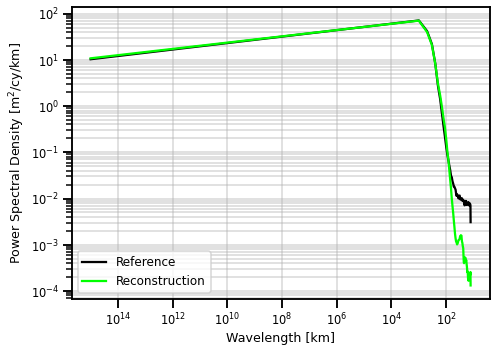

In [72]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb_logger.experiment.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

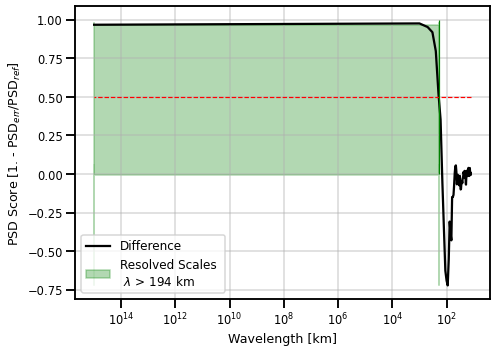

In [73]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb_logger.experiment.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

### Movies

In [74]:
wandb_logger.experiment.finish()

model_nrmse_mean,█▁
model_nrmse_std,▁█
model_rmse_mean,▁█
model_rmse_std,█▁
resolved_scale,▁█
epoch,9999
model_nrmse_mean,0.83231
model_nrmse_std,0.09396
model_rmse_mean,0.09911
model_rmse_std,0.02826
resolved_scale,194.35709


In [54]:
# save_path = wandb.run.dir #Path(root).joinpath("experiments/dc_2021b")

In [55]:
# import hvplot.xarray


# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

In [56]:
# create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)

<!-- ![](wandb/run-20220601_174733-kx2nr6qb/files/movie_pred.gif) -->

In [57]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh, f"pred", "time", cmap="viridis", file_path=save_path)


In [58]:
# wandb.log(
#     {
#         "predictions_gif": wandb.Image(f"{save_path}/movie_pred.gif"),
#     }
# )

### Gradients

In [59]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [60]:
# ds_oi.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="Spectral_r")

In [61]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_grad.isel(time=slice(50,60)), f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_grad, f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)

In [62]:
# wandb.log(
#     {
#         "predictions_grad_gif": wandb.Image(f"{save_path}/movie_pred_grad.gif"),
#     }
# )

### Laplacian

In [63]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [64]:
# ds_oi.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="RdBu_r")

In [65]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_lap.isel(time=slice(50,60)), f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_lap, f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)


In [66]:
# wandb.log(
#     {
#         "predictions_laplacian_gif": wandb.Image(f"{save_path}/movie_pred_lap.gif"),
#     }
# )